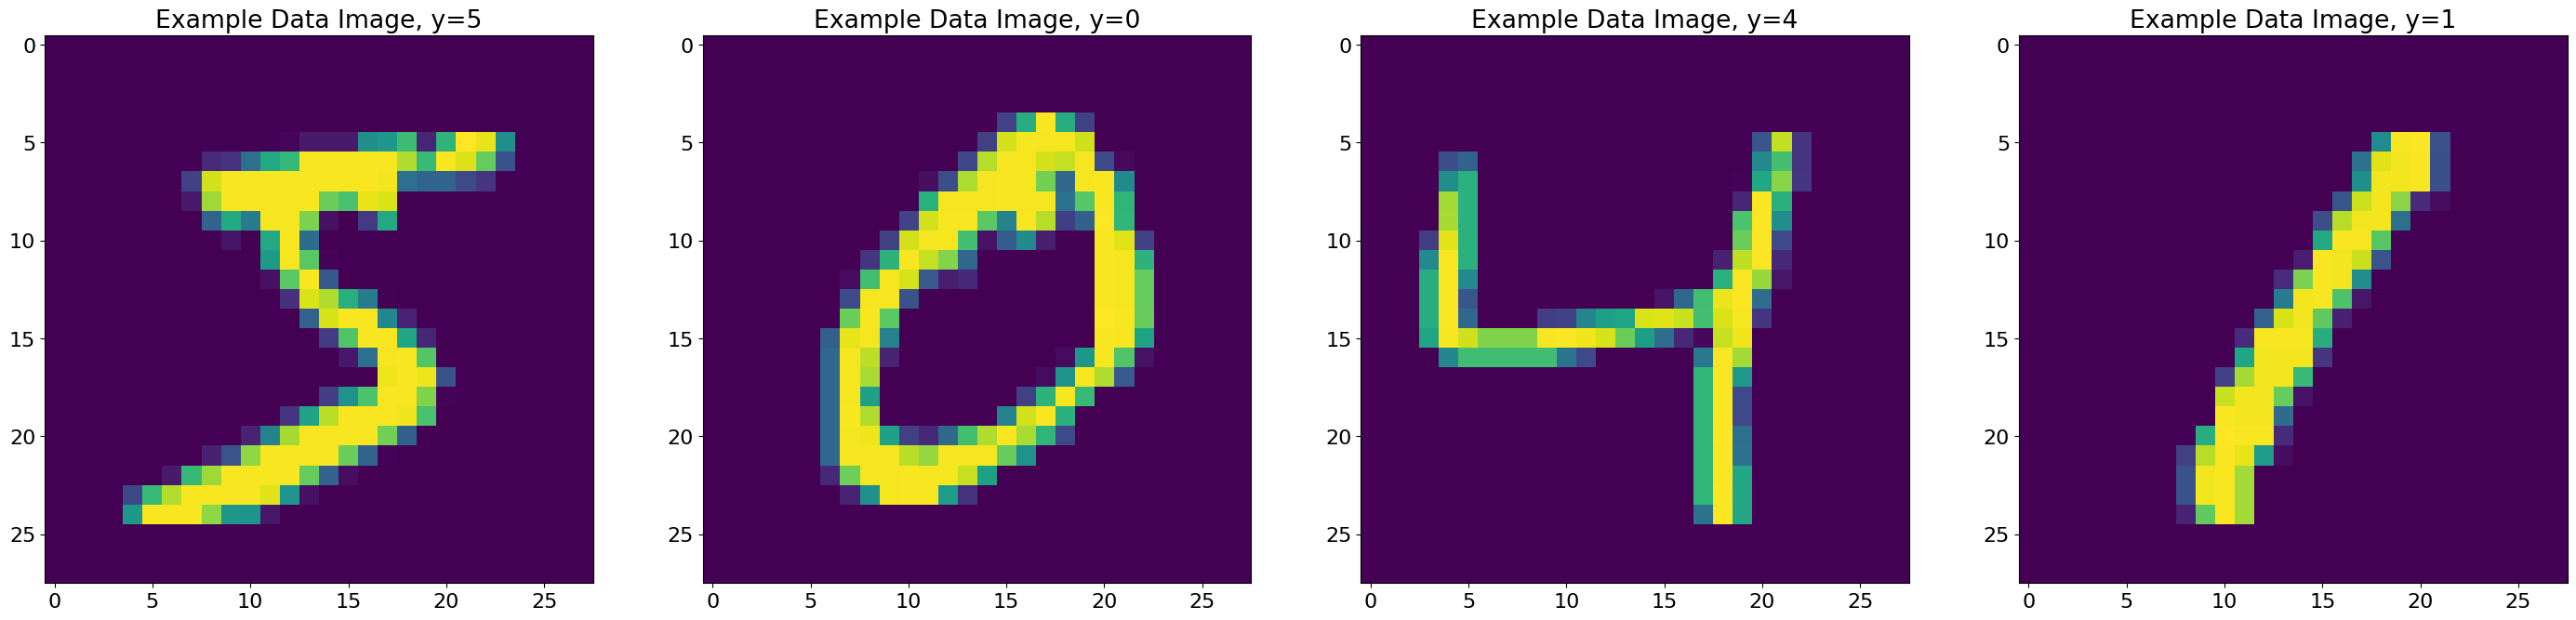

Device:  cpu
DeepVIB(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=1024, out_features=256, bias=True)
  (fc_std): Linear(in_features=1024, out_features=256, bias=True)
  (decoder): Linear(in_features=256, out_features=10, bias=True)
)
Epoch: 1/30... Train Loss: 0.8309... Train Accuracy: 0.8524... Val Loss: 0.3857... Val Accuracy: 0.9278... Time Taken: 24.3822 seconds
Epoch: 2/30... Train Loss: 0.3193... Train Accuracy: 0.9415... Val Loss: 0.2556... Val Accuracy: 0.9531... Time Taken: 24.1998 seconds
Epoch: 3/30... Train Loss: 0.2241... Train Accuracy: 0.9612... Val Loss: 0.1982... Val Accuracy: 0.9639... Time Taken: 24.4296 seconds
Epoch: 4/30... Train Loss: 0.1742... Train Accuracy: 0.9718... Val Loss: 0.1630... Val Accuracy: 0.9711... Time Taken: 24.4565 seconds
Epoch: 5/30... Train Loss: 0

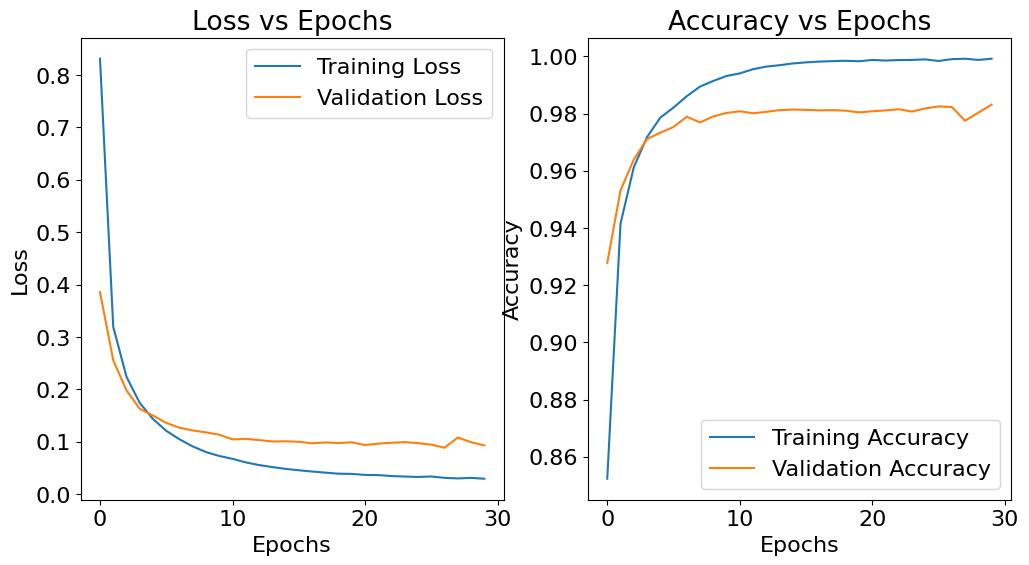

In [25]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
np.random.seed(seed)

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

# Load MNIST dataset
train_data = MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_data = MNIST('data', train=False, download=True, transform=transforms.ToTensor())

x_train = train_data.data.float() / 255
y_train = train_data.targets
x_test = test_data.data.float() / 255
y_test = test_data.targets

# Save as .npz
np.savez_compressed('data/mnist_train', a=x_train, b=y_train)
np.savez_compressed('data/mnist_test', a=x_test, b=y_test)

# Load MNIST data locally
train_data = np.load('data/mnist_train.npz')
x_train = torch.Tensor(train_data['a'])
y_train = torch.Tensor(train_data['b']).long()
n_classes = len(np.unique(y_train))

test_data = np.load('data/mnist_test.npz')
x_test = torch.Tensor(test_data['a'])
y_test = torch.Tensor(test_data['b']).long()

# Visualise data
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 4, figsize=(35, 35))
imx, imy = (28, 28)
labels = [0, 1, 2, 3]
for i, ax in enumerate(axes):
    visual = np.reshape(x_train[labels[i]], (imx, imy))
    ax.set_title("Example Data Image, y=" + str(int(y_train[labels[i]])))
    ax.imshow(visual, vmin=0, vmax=1)
plt.show()

class DeepVIB(nn.Module):
    def __init__(self, input_shape, output_shape, z_dim):
        super(DeepVIB, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.z_dim = z_dim

        # build encoder
        self.encoder = nn.Sequential(nn.Linear(input_shape, 1024),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(1024, 1024),
                                     nn.ReLU(inplace=True))
        self.fc_mu = nn.Linear(1024, self.z_dim)
        self.fc_std = nn.Linear(1024, self.z_dim)

        # build decoder
        self.decoder = nn.Linear(self.z_dim, output_shape)

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), F.softplus(self.fc_std(x) - 5, beta=1)

    def decode(self, z):
        return self.decoder(z)

    def reparameterise(self, mu, std):
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        mu, std = self.encode(x_flat)
        z = self.reparameterise(mu, std)
        return self.decode(z), mu, std

# Hyperparameters
beta = 1e-3
z_dim = 256
epochs = 30
batch_size = 128
learning_rate = 1e-4
decay_rate = 0.97

# Create DataLoader
train_dataset = data_utils.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = data_utils.TensorDataset(x_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loss function: Cross Entropy Loss (CE) + beta*KL divergence
def loss_function(y_pred, y, mu, std):
    CE = F.cross_entropy(y_pred, y, reduction='sum')
    KL = 0.5 * torch.sum(mu.pow(2) + std.pow(2) - 2 * std.log() - 1)
    return (beta * KL + CE) / y.size(0)

# Initialize Deep VIB
vib = DeepVIB(np.prod(x_train[0].shape), n_classes, z_dim)

# Optimizer
optimizer = torch.optim.Adam(vib.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

# Send to GPU if available
vib.to(device)

print("Device: ", device)
print(vib)

# Training
measures = defaultdict(list)
start_time = time.time()

# Put Deep VIB into train mode
vib.train()

for epoch in range(epochs):
    epoch_start_time = time.time()

    # Exponential decay of learning rate every 2 epochs
    if epoch % 2 == 0 and epoch > 0:
        scheduler.step()

    batch_loss = 0
    batch_accuracy = 0
    for _, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        # Zero accumulated gradients
        vib.zero_grad()

        # Forward pass through Deep VIB
        y_pred, mu, std = vib(X)

        # Calculate loss
        loss = loss_function(y_pred, y, mu, std)
        # Backpropagation: calculating gradients
        loss.backward()
        # Update parameters of generator
        optimizer.step()

        # Save loss per batch
        batch_loss += loss.item() * X.size(0)
        # Save accuracy per batch
        y_pred = torch.argmax(y_pred, dim=1)
        batch_accuracy += int(torch.sum(y == y_pred))

    # Save losses per epoch
    measures['train_loss'].append(batch_loss / len(train_dataloader.dataset))
    # Save accuracy per epoch
    measures['train_accuracy'].append(batch_accuracy / len(train_dataloader.dataset))

    # Validation
    val_loss = 0
    val_accuracy = 0
    vib.eval()
    with torch.no_grad():
        for _, (X, y) in enumerate(test_dataloader):
            X = X.to(device)
            y = y.to(device)

            y_pred, mu, std = vib(X)
            loss = loss_function(y_pred, y, mu, std)

            val_loss += loss.item() * X.size(0)
            y_pred = torch.argmax(y_pred, dim=1)
            val_accuracy += int(torch.sum(y == y_pred))

    measures['val_loss'].append(val_loss / len(test_dataloader.dataset))
    measures['val_accuracy'].append(val_accuracy / len(test_dataloader.dataset))

    print(f"Epoch: {epoch + 1}/{epochs}...",
          f"Train Loss: {measures['train_loss'][-1]:.4f}...",
          f"Train Accuracy: {measures['train_accuracy'][-1]:.4f}...",
          f"Val Loss: {measures['val_loss'][-1]:.4f}...",
          f"Val Accuracy: {measures['val_accuracy'][-1]:.4f}...",
          f"Time Taken: {time.time() - epoch_start_time:.4f} seconds")

print(f"Total Time Taken: {time.time() - start_time:.4f} seconds")

# Plot metrics
def plot_metrics(measures):
    epochs = len(measures['train_loss'])

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), measures['train_loss'], label='Training Loss')
    plt.plot(range(epochs), measures['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), measures['train_accuracy'], label='Training Accuracy')
    plt.plot(range(epochs), measures['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    plt.show()

# Call the function after training
plot_metrics(measures)
